# Day 2: Fama-French 3-Factor Model

## Learning Objectives
- Understand the Fama-French 3-Factor Model
- Calculate SMB (Small Minus Big) and HML (High Minus Low) factors
- Run multi-factor regressions
- Compare model performance with CAPM

## Key Formula
$$R_i - R_f = \alpha_i + \beta_i^M(R_m - R_f) + \beta_i^{SMB}SMB + \beta_i^{HML}HML + \epsilon_i$$

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("FAMA-FRENCH 3-FACTOR MODEL - DAY 2")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

FAMA-FRENCH 3-FACTOR MODEL - DAY 2
Data: 1834 days, 63 assets


## 1. Construct Proxy Factors

Since we don't have actual FF factors, we'll construct proxies from our data.

In [2]:
# Define stock characteristics (market cap proxy)
# Using volatility as a proxy for size (small caps tend to be more volatile)
volatilities = returns.std()

# Classify stocks as Small or Big based on volatility
median_vol = volatilities.median()
small_stocks = volatilities[volatilities > median_vol].index.tolist()
big_stocks = volatilities[volatilities <= median_vol].index.tolist()

# Remove market proxy from lists
if 'SPY' in small_stocks:
    small_stocks.remove('SPY')
if 'SPY' in big_stocks:
    big_stocks.remove('SPY')

print(f"Small-cap proxies ({len(small_stocks)} stocks): {small_stocks[:5]}...")
print(f"Big-cap proxies ({len(big_stocks)} stocks): {big_stocks[:5]}...")

# Construct SMB factor
small_returns = returns[small_stocks].mean(axis=1)
big_returns = returns[big_stocks].mean(axis=1)
SMB = small_returns - big_returns

print(f"\nSMB Factor Statistics:")
print(f"   Mean (annual): {SMB.mean() * TRADING_DAYS:.2%}")
print(f"   Volatility (annual): {SMB.std() * np.sqrt(TRADING_DAYS):.2%}")

Small-cap proxies (31 stocks): ['AAPL', 'GOOGL', 'NVDA', 'META', 'AVGO']...
Big-cap proxies (31 stocks): ['MSFT', 'BLK', 'JNJ', 'PFE', 'ABBV']...

SMB Factor Statistics:
   Mean (annual): 12.68%
   Volatility (annual): 20.37%


In [3]:
# Construct HML factor using momentum as proxy for value
# (In practice, you'd use book-to-market ratios)

# Use past 6-month returns to classify
past_returns = returns.rolling(126).mean().iloc[-1]

# Value = low momentum (beaten down), Growth = high momentum
median_ret = past_returns.median()
value_stocks = past_returns[past_returns < median_ret].index.tolist()
growth_stocks = past_returns[past_returns >= median_ret].index.tolist()

# Remove market proxy
if 'SPY' in value_stocks:
    value_stocks.remove('SPY')
if 'SPY' in growth_stocks:
    growth_stocks.remove('SPY')

print(f"Value proxies ({len(value_stocks)} stocks): {value_stocks[:5]}...")
print(f"Growth proxies ({len(growth_stocks)} stocks): {growth_stocks[:5]}...")

# Construct HML factor (High B/M minus Low B/M)
value_returns = returns[value_stocks].mean(axis=1)
growth_returns = returns[growth_stocks].mean(axis=1)
HML = value_returns - growth_returns

print(f"\nHML Factor Statistics:")
print(f"   Mean (annual): {HML.mean() * TRADING_DAYS:.2%}")
print(f"   Volatility (annual): {HML.std() * np.sqrt(TRADING_DAYS):.2%}")

Value proxies (31 stocks): ['MSFT', 'META', 'ORCL', 'CRM', 'JPM']...
Growth proxies (31 stocks): ['AAPL', 'GOOGL', 'NVDA', 'AVGO', 'BAC']...

HML Factor Statistics:
   Mean (annual): -7.65%
   Volatility (annual): 17.92%


In [4]:
# Market factor
market_returns = returns['SPY']
daily_rf = RISK_FREE_RATE / TRADING_DAYS
MKT = market_returns - daily_rf

# Combine factors
factors = pd.DataFrame({
    'MKT': MKT,
    'SMB': SMB,
    'HML': HML
}).dropna()

print("\n" + "="*60)
print("FACTOR CORRELATION MATRIX")
print("="*60)
print(factors.corr().round(4))

print("\n💡 Ideal: Low correlations between factors (orthogonal risk sources)")


FACTOR CORRELATION MATRIX
        MKT     SMB     HML
MKT  1.0000  0.4217 -0.2652
SMB  0.4217  1.0000  0.4197
HML -0.2652  0.4197  1.0000

💡 Ideal: Low correlations between factors (orthogonal risk sources)


## 2. Run 3-Factor Regression

In [5]:
def run_ff3_regression(stock_returns, factors, daily_rf):
    """Run Fama-French 3-Factor regression."""
    excess_returns = stock_returns - daily_rf
    
    # Align data
    aligned = pd.concat([excess_returns, factors], axis=1).dropna()
    y = aligned.iloc[:, 0]
    X = sm.add_constant(aligned[['MKT', 'SMB', 'HML']])
    
    model = sm.OLS(y, X).fit()
    return model

# Run regression for test stocks
test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ']

print("\n" + "="*70)
print("FAMA-FRENCH 3-FACTOR REGRESSION RESULTS")
print("="*70)
print(f"{'Stock':<8} {'Alpha':<10} {'β_MKT':<10} {'β_SMB':<10} {'β_HML':<10} {'R²':<8}")
print("-"*70)

ff3_results = []
for stock in test_stocks:
    if stock in returns.columns:
        model = run_ff3_regression(returns[stock], factors, daily_rf)
        
        result = {
            'stock': stock,
            'alpha': model.params['const'] * TRADING_DAYS,
            'beta_mkt': model.params['MKT'],
            'beta_smb': model.params['SMB'],
            'beta_hml': model.params['HML'],
            'r2': model.rsquared
        }
        ff3_results.append(result)
        
        print(f"{stock:<8} {result['alpha']:<10.4%} {result['beta_mkt']:<10.4f} "
              f"{result['beta_smb']:<10.4f} {result['beta_hml']:<10.4f} {result['r2']:<8.4f}")

ff3_df = pd.DataFrame(ff3_results)


FAMA-FRENCH 3-FACTOR REGRESSION RESULTS
Stock    Alpha      β_MKT      β_SMB      β_HML      R²      
----------------------------------------------------------------------
AAPL     11.6935%   1.2650     -0.0724    0.0475     0.6050  
MSFT     9.3698%    1.3254     -0.2576    0.2387     0.6647  
JPM      0.0075%    0.8029     0.4386     -0.3078    0.5495  
XOM      -6.5105%   0.2633     0.8086     -0.7495    0.4259  
JNJ      6.2038%    0.6946     -0.3888    0.3868     0.2982  


## 3. Compare with CAPM

In [6]:
def run_capm_regression(stock_returns, market_returns, daily_rf):
    """Run CAPM regression."""
    excess_stock = stock_returns - daily_rf
    excess_market = market_returns - daily_rf
    
    X = sm.add_constant(excess_market)
    model = sm.OLS(excess_stock, X).fit()
    return model

print("\n" + "="*60)
print("MODEL COMPARISON: CAPM vs FF3")
print("="*60)
print(f"{'Stock':<8} {'CAPM R²':<12} {'FF3 R²':<12} {'Improvement':<12}")
print("-"*60)

comparisons = []
for stock in test_stocks:
    if stock in returns.columns:
        capm = run_capm_regression(returns[stock], market_returns, daily_rf)
        ff3 = run_ff3_regression(returns[stock], factors, daily_rf)
        
        improvement = ff3.rsquared - capm.rsquared
        
        comparisons.append({
            'stock': stock,
            'capm_r2': capm.rsquared,
            'ff3_r2': ff3.rsquared,
            'improvement': improvement
        })
        
        print(f"{stock:<8} {capm.rsquared:<12.4f} {ff3.rsquared:<12.4f} {improvement:<12.4f}")

print("\n💡 Higher R² means more return variation explained by the model")


MODEL COMPARISON: CAPM vs FF3
Stock    CAPM R²      FF3 R²       Improvement 
------------------------------------------------------------
AAPL     0.6038       0.6050       0.0012      
MSFT     0.6443       0.6647       0.0204      
JPM      0.5014       0.5495       0.0482      
XOM      0.2599       0.4259       0.1660      
JNJ      0.1921       0.2982       0.1061      

💡 Higher R² means more return variation explained by the model


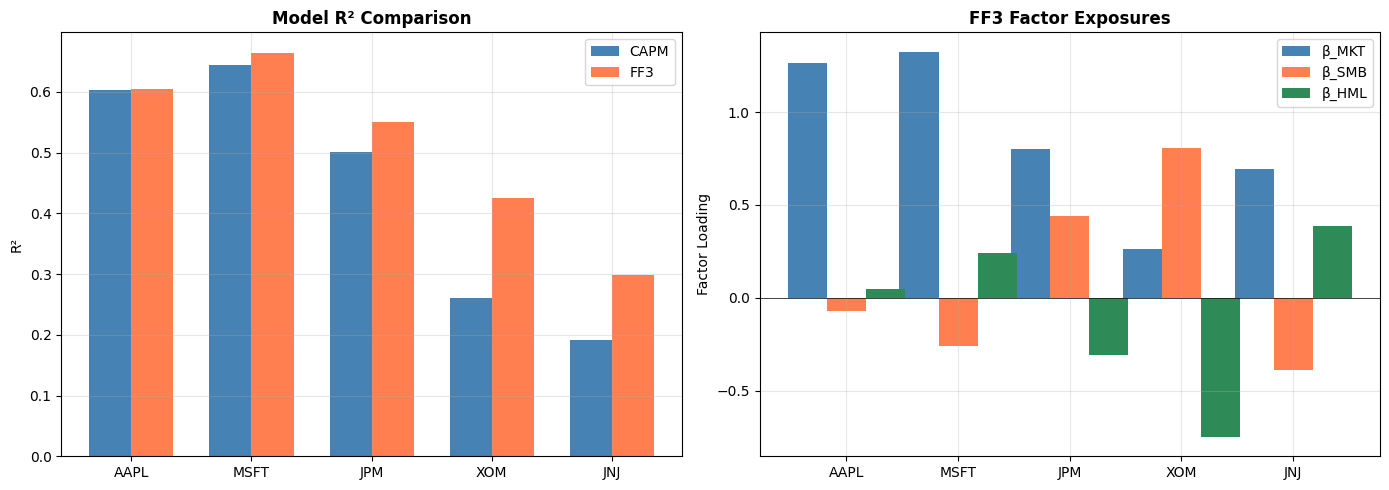

In [7]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comp_df = pd.DataFrame(comparisons)

# R² Comparison
x = np.arange(len(test_stocks))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, comp_df['capm_r2'], width, label='CAPM', color='steelblue')
ax1.bar(x + width/2, comp_df['ff3_r2'], width, label='FF3', color='coral')
ax1.set_xticks(x)
ax1.set_xticklabels(comp_df['stock'])
ax1.set_ylabel('R²')
ax1.set_title('Model R² Comparison', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Factor Loadings
ax2 = axes[1]
ax2.bar(x - width, ff3_df['beta_mkt'], width, label='β_MKT', color='steelblue')
ax2.bar(x, ff3_df['beta_smb'], width, label='β_SMB', color='coral')
ax2.bar(x + width, ff3_df['beta_hml'], width, label='β_HML', color='seagreen')
ax2.set_xticks(x)
ax2.set_xticklabels(ff3_df['stock'])
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Factor Loading')
ax2.set_title('FF3 Factor Exposures', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Alpha Analysis

In [8]:
print("="*70)
print("ALPHA SIGNIFICANCE: CAPM vs FF3")
print("="*70)
print(f"{'Stock':<8} {'CAPM α':<12} {'CAPM p-val':<12} {'FF3 α':<12} {'FF3 p-val':<12}")
print("-"*70)

for stock in test_stocks:
    if stock in returns.columns:
        capm = run_capm_regression(returns[stock], market_returns, daily_rf)
        ff3 = run_ff3_regression(returns[stock], factors, daily_rf)
        
        capm_alpha = capm.params.iloc[0] * TRADING_DAYS
        capm_pval = capm.pvalues.iloc[0]
        ff3_alpha = ff3.params['const'] * TRADING_DAYS
        ff3_pval = ff3.pvalues['const']
        
        print(f"{stock:<8} {capm_alpha:<12.4%} {capm_pval:<12.4f} {ff3_alpha:<12.4%} {ff3_pval:<12.4f}")

print("\n💡 Alpha often decreases from CAPM to FF3")
print("   - CAPM alpha may be 'false alpha' due to factor exposure")
print("   - FF3 provides a more complete picture of return sources")

ALPHA SIGNIFICANCE: CAPM vs FF3
Stock    CAPM α       CAPM p-val   FF3 α        FF3 p-val   
----------------------------------------------------------------------
AAPL     10.9514%     0.1239       11.6935%     0.1005      
MSFT     6.4053%      0.2985       9.3698%      0.1179      


JPM      4.5977%      0.5502       0.0075%      0.9992      
XOM      2.7956%      0.7749       -6.5105%     0.4504      


JNJ      1.6073%      0.7987       6.2038%      0.2919      

💡 Alpha often decreases from CAPM to FF3
   - CAPM alpha may be 'false alpha' due to factor exposure
   - FF3 provides a more complete picture of return sources


## 5. Factor Return Analysis

/var/folders/7l/31hylb_513bbgfbz8nnsgp840000gn/T/ipykernel_23120/2028842905.py:32: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  factors.hist(bins=50, ax=ax3, alpha=0.7)


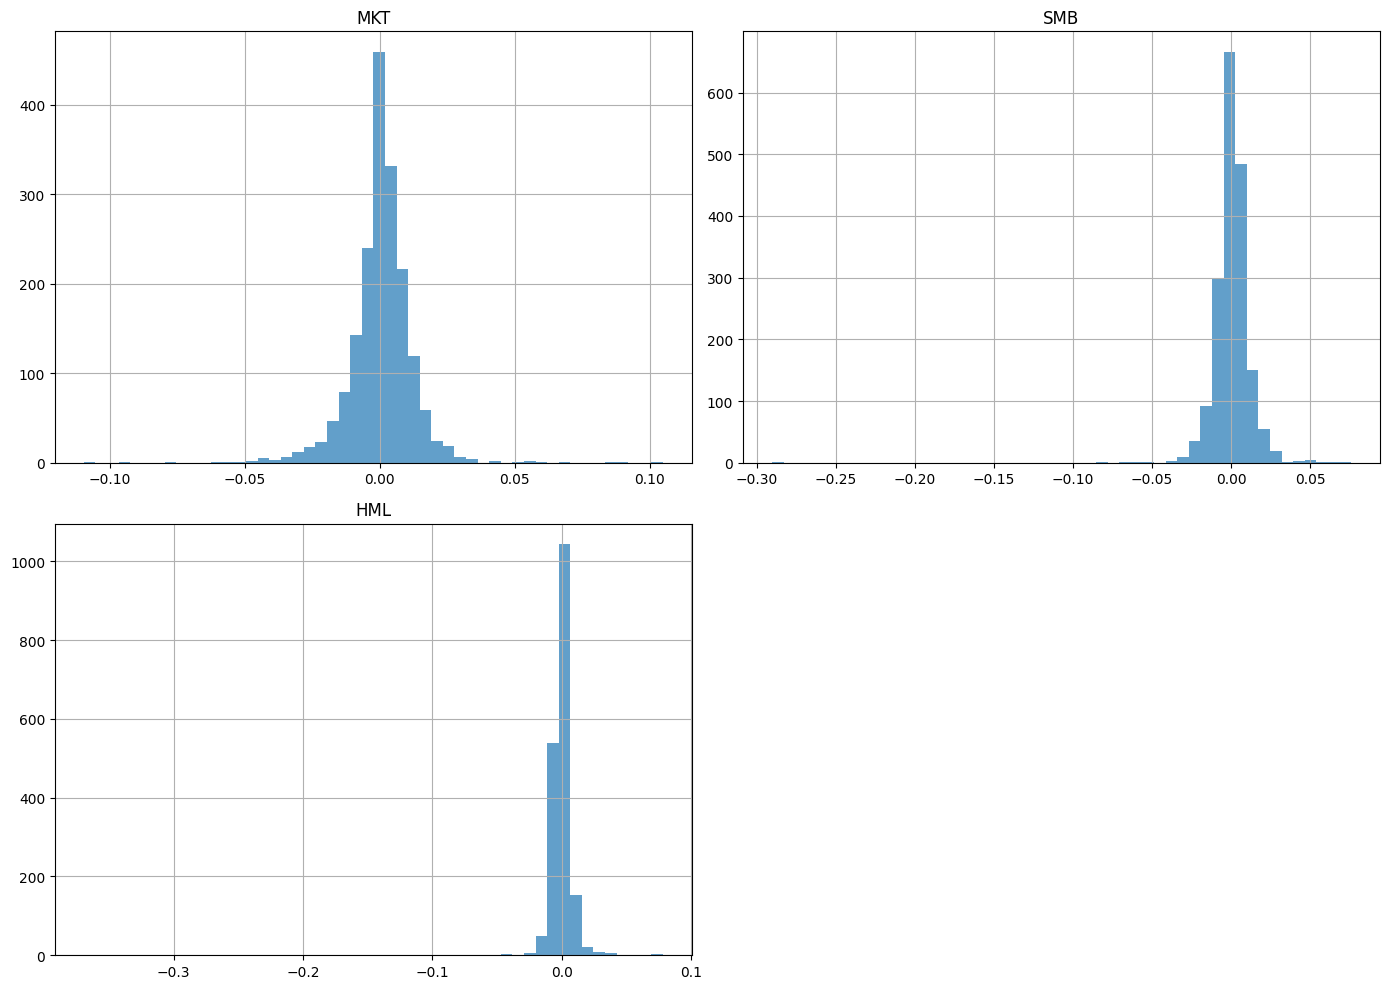


📊 Factor Statistics Summary:
     Mean (Ann.)  Vol (Ann.)  Sharpe
MKT       0.1232      0.1938  0.6356
SMB       0.1268      0.2037  0.6224
HML      -0.0765      0.1792 -0.4268


In [9]:
# Cumulative factor returns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative returns
ax1 = axes[0, 0]
cum_mkt = (1 + factors['MKT']).cumprod()
cum_smb = (1 + factors['SMB']).cumprod()
cum_hml = (1 + factors['HML']).cumprod()

ax1.plot(cum_mkt, label='Market', linewidth=2)
ax1.plot(cum_smb, label='SMB', linewidth=2)
ax1.plot(cum_hml, label='HML', linewidth=2)
ax1.set_title('Cumulative Factor Returns', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('Cumulative Return')

# Rolling Sharpe
ax2 = axes[0, 1]
window = 60
for col in ['MKT', 'SMB', 'HML']:
    rolling_sharpe = (factors[col].rolling(window).mean() / 
                      factors[col].rolling(window).std() * np.sqrt(TRADING_DAYS))
    ax2.plot(rolling_sharpe, label=col)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Rolling 60-Day Sharpe Ratio', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Distribution
ax3 = axes[1, 0]
factors.hist(bins=50, ax=ax3, alpha=0.7)
ax3.set_title('Factor Return Distributions', fontweight='bold')

# Factor statistics
ax4 = axes[1, 1]
stats_df = pd.DataFrame({
    'Mean (Ann.)': factors.mean() * TRADING_DAYS,
    'Vol (Ann.)': factors.std() * np.sqrt(TRADING_DAYS),
    'Sharpe': (factors.mean() * TRADING_DAYS) / (factors.std() * np.sqrt(TRADING_DAYS))
})
stats_df.plot(kind='bar', ax=ax4)
ax4.set_title('Factor Statistics', fontweight='bold')
ax4.legend(loc='upper right')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 Factor Statistics Summary:")
print(stats_df.round(4))

## Key Takeaways

1. **Fama-French 3-Factor** adds Size (SMB) and Value (HML) to CAPM
2. **SMB** captures small-cap premium
3. **HML** captures value premium
4. **Higher R²** than CAPM - explains more return variation
5. **Alpha often decreases** when accounting for additional factors

---
*Next: Day 3 - Fama-French 5-Factor Model*